In [1]:
from dask.distributed import Client, wait
from dask import delayed, persist
import dask.array as da

from functions import cholesky_tsqr, indirect_tsqr, direct_tsqr
import numpy as np

import time
import gc

In [2]:
def benchmark(client : Client, X_da : da.Array, algorithm : callable, rep : int = 20, verbose : bool = False) -> list:
    '''
    Benchmark a given QR algorithm on a Dask array
    
    Parameters
    ----------
    client : dask.distributed.Client
        Dask client to manage the computation.
    X_da : dask.array.Array
        Input matrix (m x n), stored as a Dask array.
    algorithm : delayed function
        The algorithm to benchmark. Should return Q, R.
    rep : int, optional
        Number of repetitions for the benchmark (default is 20).
    verbose : bool, optional
        If True, prints progress information (default is False).

    Returns
    -------
    times : list
        List of execution times for each repetition.
    '''
    res = []
    if verbose:
        print("Fun:", algorithm.__name__, ", completion status: ", end="")
    
    for i in range(rep):
        if verbose:
            print(i, end=" ")

        start = time.time()

        # Launch the function and trigger the computation
        # by persisting the results
        Q, R = algorithm(X_da)
        Q, R = persist(Q, R)
        wait([Q, R])

        end = time.time()
        res.append(end - start)

        # Resetting the client memory by cancelling
        # the futures and triggering garbage collection
        client.cancel([Q, R])
        gc.collect()
        client.run(gc.collect)

    if verbose:
        print()

    return res

def write_stats_dim(filename : str, param : str, times : list):
    '''
    Write the statistics of the benchmark to a file.

    | param | avg | std | med | mad |

    Parameters
    ----------
    filename : str
        The name of the file to write the statistics to.
    param : str
        The name of the parameter being tested.
    times : list
        List of execution times from the benchmark.
    '''
    avg = np.mean(times)
    std = np.std(times)
    med = np.median(times)
    mad = np.median(np.abs(times - med))
    with open(filename, "a") as f:
        f.write(f"{param} {avg} {std} {med} {mad}\n")

def create_dataset(file_path : str, shape : tuple, dtype : type, chunk_size : int):
    '''
    Create a  random dataset and save it to a file.
    
    Parameters
    ----------
    file_path : str
        The path to the file where the dataset will be saved.
    shape : tuple
        The shape of the dataset (m, n).
    dtype : data-type
        The desired data-type for the array.
    chunk_size : int
        The number of rows per chunk to write to the file.
    '''
    m, n = shape
    
    with open(file_path, "a") as f:
        for _ in range(m // chunk_size):
            # Generate a chunk of random data
            X_chunk = np.random.randn(chunk_size, n).astype(dtype)
            np.savetxt(f, X_chunk, delimiter=",")

        # Handle any remaining rows
        if m % chunk_size != 0:
            X_chunk = np.random.randn(m % chunk_size, n).astype(dtype)
            np.savetxt(f, X_chunk, delimiter=",")

In [3]:
m = [int(1e5), int(5e5), int(1e6), int(5e6), int(1e7), 
    int(2e7), int(3e7), int(4e7), int(5e7), int(6e7)]   # Number of rows
n = 4                                                   # Number of columns (fixed n << m)

# Number of repetitions for each test
rep = 20

## Sequential test
#### **System specifications**
- CPU: Intel Core i7-14700K (20 Core, 28 Threads - Turbo Frequency 5.6 GHz)
- RAM: 32 GB (DDR5)

In [10]:
# Initialize Dask client with a single worker
client = Client(
    n_workers=1,
    threads_per_worker=1,
    memory_limit="16GB",
)

print("Dashboard:", client.dashboard_link)

Dashboard: http://127.0.0.1:8787/status


In [11]:
for mi in m:
    # Creation of a random dask array inside the worker
    X_np = da.random.random((mi, n))
    X_np.persist()
    print(f"Input matrix A: m = {X_np.shape[0]}, n = {X_np.shape[1]}")
    print(f"Total size of A: {X_np.nbytes / 1e6} MB")

    times = []
    for i in range(rep):
        start = time.time()

        # Numpy QR decomposition. We use persist to trigger
        # the computation and avoid data transfering
        QR = delayed(np.linalg.qr)(X_np)
        QR = client.persist([QR])
        wait([QR])

        end = time.time()
        times.append(end - start)

        # Clean memory from previous computations
        client.cancel(QR)
        gc.collect()
        client.run(gc.collect)

    # Clean memory from previous computations    
    client.cancel(X_np)
    gc.collect()
    client.run(gc.collect)

    # Save statistics
    print(f"NumPy: mean time {np.mean(times):.2f} s, std {np.std(times):.2f} s")
    write_stats_dim(f"./data/Size_NumPy.txt", X_np.shape[0], times)
    print()

Input matrix A: m = 100000, n = 4
Total size of A: 3.2 MB
NumPy: mean time 0.03 s, std 0.02 s

Input matrix A: m = 500000, n = 4
Total size of A: 16.0 MB
NumPy: mean time 0.05 s, std 0.00 s

Input matrix A: m = 1000000, n = 4
Total size of A: 32.0 MB
NumPy: mean time 0.09 s, std 0.01 s

Input matrix A: m = 5000000, n = 4
Total size of A: 160.0 MB
NumPy: mean time 0.46 s, std 0.03 s

Input matrix A: m = 10000000, n = 4
Total size of A: 320.0 MB
NumPy: mean time 0.94 s, std 0.07 s

Input matrix A: m = 20000000, n = 4
Total size of A: 640.0 MB
NumPy: mean time 1.91 s, std 0.09 s

Input matrix A: m = 30000000, n = 4
Total size of A: 960.0 MB
NumPy: mean time 2.78 s, std 0.09 s

Input matrix A: m = 40000000, n = 4
Total size of A: 1280.0 MB
NumPy: mean time 3.70 s, std 0.12 s

Input matrix A: m = 50000000, n = 4
Total size of A: 1600.0 MB
NumPy: mean time 4.58 s, std 0.11 s

Input matrix A: m = 60000000, n = 4
Total size of A: 1920.0 MB
NumPy: mean time 5.67 s, std 0.11 s



In [10]:
client.close()

## Parallel tests

In [9]:
# Initialize Dask client with multiple workers
N_WORKERS = 12
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "2.5GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

DASK Client with 12 workers (1 threads, 2.5GB memory)
Dashboard: http://127.0.0.1:8787/status


In [5]:
# Define the algorithms to benchmark
algorithms = {
    "Size_Cholesky": cholesky_tsqr,     # Cholesky-based TSQR (Cholesky.ipynb)
    "Size_Indirect": indirect_tsqr,     # Indirect TSQR (Indirect.ipynb)
    "Size_Direct": direct_tsqr,         # Direct TSQR (Direct.ipynb)
    "Size_Dask": da.linalg.tsqr         # Dask-based TSQR (https://docs.dask.org/en/stable/generated/dask.array.linalg.tsqr.html)
}

for mi in m:
    # Creation of a random dask array inside the worker
    # subdivided evenly in N_WORKERS chunks.
    chunks = [mi // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(mi - sum(chunks))
    X_da = da.random.random((mi, n), chunks=(chunks, n))
    X_da = X_da.persist()

    print(f"Input matrix A: m = {X_da.shape[0]}, n = {X_da.shape[1]}")
    print(f"The {len(X_da.chunks[0])} blocks are: {X_da.chunks[0]}")
    print(f"Total size of A: {X_da.nbytes / 1e6} MB")
    wait(X_da)

    for name, alg in algorithms.items():
        times = benchmark(client, X_da, alg, rep=rep, verbose=True)
        print(f"{name}: mean time {np.mean(times):.2f} s, std {np.std(times):.2f} s")
        write_stats_dim(f"./data/{name}.txt", X_da.shape[0], times)
    print()

    # Clean memory from previous computations
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)

Input matrix A: m = 100000, n = 4
The 12 blocks are: (8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8337)
Total size of A: 3.2 MB
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Cholesky: mean time 0.04 s, std 0.00 s
Fun: indirect_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Indirect: mean time 0.09 s, std 0.00 s
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Direct: mean time 0.06 s, std 0.00 s
Fun: tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Dask: mean time 0.05 s, std 0.01 s

Input matrix A: m = 500000, n = 4
The 12 blocks are: (41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41674)
Total size of A: 16.0 MB
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Cholesky: mean time 0.04 s, std 0.00 s
Fun: indirect_tsqr , complet

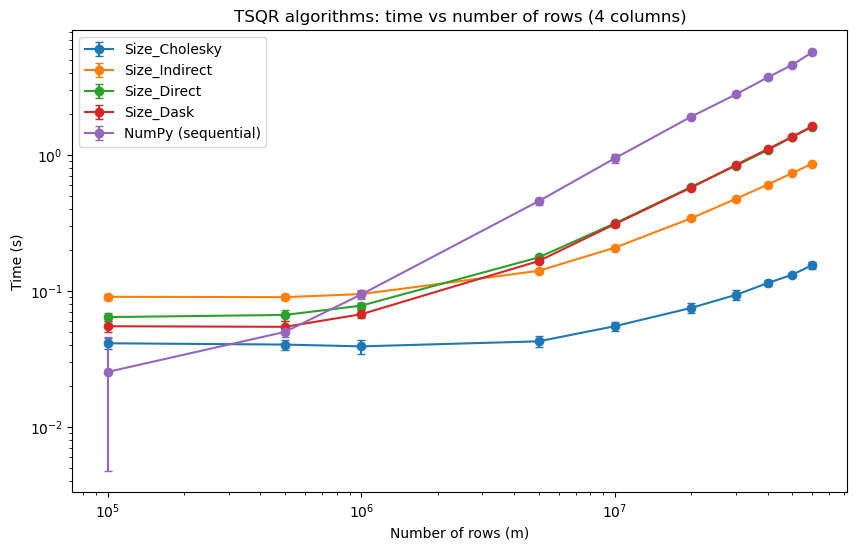

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for name in algorithms.keys():
    data = np.loadtxt(f"./data/{name}.txt")
    plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], label=name, marker='o', capsize=3)

data_numpy = np.loadtxt("./data/Size_NumPy.txt")
plt.errorbar(data_numpy[:, 0], data_numpy[:, 1], yerr=data_numpy[:, 2], label="NumPy (sequential)", marker='o', capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.title(f"TSQR algorithms: time vs number of rows ({n} columns)")
plt.xlabel("Number of rows (m)")
plt.ylabel("Time (s)")
plt.legend()
plt.show()